Assignment4  - Maze Navigation with Genetic Algorithm

by Wenbo Wang

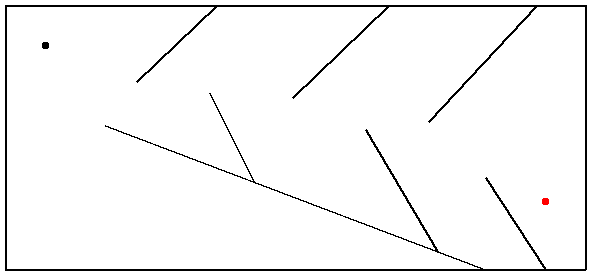

##Google Drive Integration - To save maze images

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pwd
%cd drive
!ls
%cd 'MyDrive'

# !mkdir 'IS698-Assignment4-data'
%cd 'IS698-Assignment4-data'

pwd = !pwd
print(f"Note: Our image files will save in {pwd}")

/content
/content/drive
MyDrive  Shareddrives
/content/drive/MyDrive
/content/drive/MyDrive/IS698-Assignment4-data
Note: Our image files will save in ['/content/drive/MyDrive/IS698-Assignment4-data']


## Academic References

Adapted from:
* J. Lehman & K.O. Stanley (2011). Abandoning Objectives: Evolution Through the Search for Novelty Alone. *Evolutionary Computation* 19(2): 189-223. https://doi.org/10.1162/EVCO_a_00025.

In particular, the domain definition is based primarily on Figures 1-2 from that paper:

![Lehman & Stanley (2011), Figures 1-2](http://www.kmjn.org/temp/robotdomain.png)

## Mazes


Visualization


In [3]:
import math
from PIL import Image, ImageDraw
from IPython.display import display

scalefactor = 40 # pixels per 'maze unit' for vis purposes
border = 5       # in pixels
markersize = 3   # in pixels, should be even
linewidth = 2    # in pixels

# convert world-space coordinate to pixel coordinate
def coord(x):
  if type(x) is list:
    return [coord(elem) for elem in x]
  elif type(x) is tuple:
    return tuple(coord(elem) for elem in x)
  else:
    return int(scalefactor*x) + border

# returns bounds for ImageDraw.Draw.ellipse()
def marker(x):
  return list(i - markersize for i in coord(x)) + list(i + markersize for i in coord(x))


def showmaze(m,i):
  width = m['dimensions'][0]
  height = m['dimensions'][1]
  img = Image.new("RGB", (int(width*scalefactor) + 2*border, int(height*scalefactor) + 2*border), 'white')
  img1 = ImageDraw.Draw(img)
  img1.rectangle(coord([0.0, 0.0, width, height]), None, 'black')
  img1.ellipse(marker(m['position']), 'black')
  img1.ellipse(marker(m['goal']), 'red')
  for obstacle in m['obstacles']:
    img1.line(coord(obstacle), 'black', linewidth)
  mazeNamePNG = "maze_" + str(i) + ".png"
  img.save(mazeNamePNG)
  display(img)
 

"Medium" maze



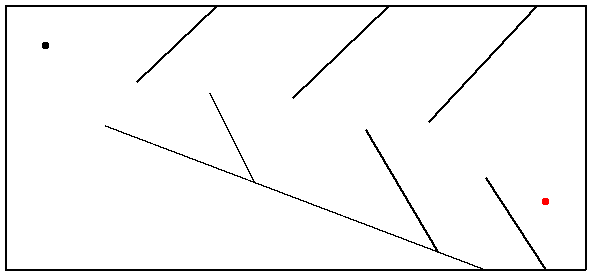

In [4]:
#(Lehman and Stanley, 2011, Figure 2)
mediumWidth = 14.5
mediumHeight = 6.6
mediumMaze = {
    'dimensions': (14.5, 6.6),

    # 1. Obstacles to avoid are lines specified as [(x1,y1),(x2,y2)]
    # 2. Perimeter walls are included as the last four sets of coordinates
    # 3. The upper left corner of the maze is (0,0). The bottom right corner is (width, height)
    'obstacles': [[(2.5, 3.0),(12.0, 6.6)], [(5.1, 2.2), (6.2, 4.4)],
                  [(9.0, 3.1), (10.8, 6.15)], [(12.0, 4.3), (13.5, 6.6)],
                  [(3.3, 1.9), (5.3, 0.0)], [(7.2, 2.3), (9.6, 0.0)],
                  [(10.6, 2.9), (13.3, 0.0)],[(0.0,0.0),(mediumWidth,0.0)],
                  [(0.0,0.0),(0.0,mediumHeight)], [(mediumWidth,0.0),(mediumWidth,mediumHeight)],
                  [(0.0, mediumHeight), (mediumWidth, mediumHeight)]],
   
    'position': (1.0, 1.0),
    'heading': 0, # in radians. 0 is to the right (+x axis); increasing heading rotates clockwise
    'goal': (13.5, 4.9),
}

showmaze(mediumMaze,0)

"Hard" maze:

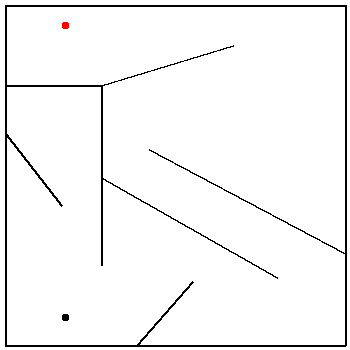

In [5]:
#(Lehman and Stanley, 2011, Figure 2)
hardWidth = 8.5
hardHeight = 8.5

hardMaze = {
    'dimensions': (8.5, 8.5),
    # 1. Obstacles to avoid are lines specified as [(x1,y1),(x2,y2)]
    # 2. Perimeter walls are included as the last four sets of coordinates
    # 3. The upper left corner of the maze is (0,0). The bottom right corner is (width, height)

    'obstacles': [[(0.0, 2.0), (2.4, 2.0)], [(2.4, 2.0), (5.7, 1.0)],
                  [(2.4, 2.0), (2.4, 6.5)], [(0.0, 3.2), (1.4, 5.0)],
                  [(2.4, 4.3), (6.8, 6.8)], [(3.3, 8.5), (4.7, 6.9)],
                  [(3.6, 3.6), (8.5, 6.2)],[(0.0,0.0),(hardWidth,0.0)],
                  [(0.0,0.0),(0.0,hardHeight)], [(hardWidth,0.0),(hardWidth,hardHeight)],
                  [(0.0, hardHeight), (hardWidth, hardHeight)]],
   
    'position': (1.5, 7.8),
    'heading': 0,
    'goal': (1.5, 0.5),
}

showmaze(hardMaze,0)

## Robot Controllers


The controller can move forward/back along the current heading, and rotate left/right to change heading (based on my intepretation of Fig. 1 at the top of this notebook). At each timestep it should return a 2-tuple:
* Forward/back speed, in the range [-1.0,1.0]. Max speed (i.e. -1.0 or 1.0) is equal to the 'speed' simulation parameter above, and lower speeds are linearly scaled.
* Left/right rotation, in the range [-1.0, 1.0]. Max rotation in either direction is 180 degrees. 0.0 means continue on the current heading, -0.5 means turn 90 degrees to the left, etc.

The controller is given a 10-element list with current sensor readings (see Fig. 1 again):
* The first six rangefinder sensors give the distance to the nearest obstacle in the directions: left, left-front, front, right-front, front, and rear (relative to current heading).
* The last four wedge sensors will have exactly one of the four set to 1.0, and the others to 0.0. The one set to 1.0 indicates the 90-degree quadrant that the goal is in, relative to the current heading. The order of the quadrants is: left, front, right, back.

Random controller:

In [6]:
import random
def randomController(sensors):
  # ignores sensors
  return (random.uniform(-1, 1), random.uniform(-1,1))

Go-straight controller:

In [7]:
def goStraight(sensors):
  # ignores sensors
  return (1.0, 0.0)

A controller that goes mostly straight, but avoids walls, mostly to test use of the sensors:

In [8]:
def goStraightAvoid(sensors):
  # go left-forward, forward, or right-forward, depending on which direction is furthest from obstacles
  if sensors[2] >= sensors[1] and sensors[2] >= sensors[3]:
    return (1.0, 0.0)        # go straight
  elif sensors[1] > sensors[3]:
    return (1.0, -0.25) # turn 45 degrees left
  return (1.0, 0.25)  # turn 45 degrees right

ANN Controller Definition

In [9]:
import math
import pprint

#Note: Used activation function tanh because -1, 1
def ANNController(sensors, network):
  return network.Evaluate(sensors)

### ANN Logic

This code is an except from Matt Fontaine's EvoSabber code available at https://github.com/tehqin/EvoStone/blob/master/DeckEvaluator/src/NeuralNet/FullyConnectedNetwork.cs

Assembled by:
*   Amy K Hoover <ahoover@njit.edu>, 11/2020

In [10]:
import numpy as np

class FullyConnectedNetwork:

  def __init__(self, networkTopology):
    self._layerSizes = networkTopology
    self._weights = []
    self._bias = []
    self.NumWeights = 0
    self.NumBias =0

    # Set self._weights such that each layer i has exactly one connection
    # to layer i + 1. 
    # Initially weights should be zero.
    # Replace TODO

    for i in range(len(self._layerSizes)-1):
      self._weights.append( np.zeros((self._layerSizes[i], self._layerSizes[i+1]))  )

    # Calculate the total number of weights for the network and the bias inputs
    # Replace TODO
    print("self._layerSizes", self._layerSizes)
    for i in range(len(self._layerSizes)-1):
      print("Numweithts += %d * %d" % (self._layerSizes[i], self._layerSizes[i+1]))
      self.NumWeights += self._layerSizes[i] * self._layerSizes[i+1]
      self.NumBias += self._layerSizes[i+1]
    
    

    # Add bias weights. Replace TODO     
    for t in range(self.NumBias):
      self._bias.append(0)

  def SetWeights(self,weightVector):
    if len(weightVector) != self.NumWeights + self.NumBias:
      print("Neural Network Logic Check")
      print("Num Weight Mismatch {len(weightVector)} vs {self.NumWeights} + {self.NumBias} = {self.NumWeights + self.NumBias}")
      print(f"Num Weight Mismatch {len(weightVector)} vs {self.NumWeights} + {self.NumBias} = {self.NumWeights + self.NumBias}")

    # Set the weights of our neural network.
    # Replace TODO
    counter = 0;
    for k  in range(len(self._layerSizes) - 1):
      for i  in range(self._layerSizes[k]):
        for j in range(self._layerSizes[k + 1]):
          self._weights[k][i][j] = weightVector[counter]
          counter +=1
    print("counter", counter)
    # Set the weights of our neural network bias
    # Replace TODO
    i = 0
    for i in range(self.NumBias):
      self._bias[i] = weightVector[counter]
      counter+=1
                         
  def Evaluate(self,input):
    if len(input) != self._layerSizes[0]:
      print("Input layer size doesn't match input vector");
      return null;    

    counter = 0
    layer = input

    # For each layer of the ANN
    for k in range(len(self._layerSizes) - 1):
      # Save the next layer 
      nextLayer = []
      i = 0
      for i in range(self._layerSizes[k + 1]):
        # Appending 0 for python hack
        nextLayer.append(0)
        # Replacing zero with value of self._bias at position counter
        nextLayer[i] = self._bias[counter];
        counter+=1
                
      i = 0
      for i in range(self._layerSizes[k]):
        for j  in range(self._layerSizes[k + 1]):
          # TODO: Set nextLayer[j] to the activation sum
          # To nextLayer[j], decide how to get the value from layer and
          # multiply it by the weights indexed by i,j,k
          # Replace TODO
          nextLayer[j] += layer[i] * self._weights[k][i,j];

      j = 0
      for j  in range(self._layerSizes[k + 1]):
        # Set previous nextLayer[j] to the activated values by calling a
        # function (it could be tanh if you want) from the math
        # library
        nextLayer[j] = math.tanh(nextLayer[j]);
        layer = nextLayer;

    return layer

## Simulation

Parameters

In [11]:
# robot max speed, in world units per timestep
SPEED = 0.1

# epsilon distance for considering goal reached, collisions, etc.
epsilon = 0.01
sqEpsilon = epsilon**2

# interval to update visualization
visInterval = 1

# max simulation timesteps
timeout = 400

Utility

In [29]:
from shapely.geometry import Point, LineString
import copy

def sqDistance(pos1, pos2):
  return (pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2

def isGoal(state):
  return sqDistance(state['position'], state['goal']) < sqEpsilon

# Given the robot's current heading, and an amount to rotate, return the new heading of the robot once it will rotate (all normalized in radians)
def rotateRobot(currentHeading, amount):
  return (currentHeading + amount) % (math.pi * 2.0)

# IF you are heading in a direction, and you need to know what heading is some offset from the current heading (the sensors need this information), return the offset heading
def findOffset(currentHeading, amount):
  return rotateRobot(currentHeading, amount)

# distance to the nearest obstacle in a given direction
def rangeSensor(pos, direction, obstacles, maxDist):
  pos2 = (pos[0] + math.cos(direction) * maxDist,
          pos[1] + math.sin(direction) * maxDist)
  testray = LineString([pos, pos2])
  collisions = [testray.intersection(obstacle) for obstacle in obstacles]
  posPt = Point(pos[0], pos[1])
  distances = [posPt.distance(c) for c in collisions if c]
  if len(distances) == 0:
    return 0
  return min(distances)

def get_score(state):
  return 1 / (sqDistance(state['position'], state['goal']) / 100)

The main simulation loop:

In [30]:
import math
from IPython.display import clear_output

# Add link to EvoSabber fully connected network here (TODO for Amy)

### A constant list that helps us easily access the angles of the following directions: 
##  angled (in order): left, left-center, center, right-center, right, back
#
RANGE_SENSOR_DIRECTIONS = [-math.pi/2, -math.pi/4, 0, math.pi/4, math.pi/2, math.pi]
NETWORK_TOPOLOGY = [10,1,1,2]


def runSimulation(initState, controller, weights):
  clear_output()

  ## Create Neural Network Controller with the default NETWORK_TOPOLOGY
  ## TODO set the controller's weights to the vector passed in through runSimulation
  network = FullyConnectedNetwork(NETWORK_TOPOLOGY)
  network.SetWeights(weights)

  # What follows is from the original runSimulation logic
  state = copy.copy(initState)
  timestep = 0
  (width, height) = state['dimensions']
  obstacles = [LineString(obstacle) for obstacle in state['obstacles']]
  maxDist = math.sqrt(width**2 + height**2) # max distance between points in the maze



  print(f"Initial state (i.e., timestep = {0}):")
  showmaze(state,timestep)

  while timestep < timeout:
    if isGoal(state):
      print("Returning before timeout!")
      return 

    timestep+= 1

    if timestep %10==0:
      print(f"Step {timestep}:")
      showmaze(state, timestep)

    ##################
    # Update Sensors #
    ##################
    
    
      ### Range Finder Sensors:
      ##  Description: These sensors find the distance to the nearest obstacle in each of the directions specified
      #   in the RANGE_SENSOR_DIRECTIONS constant

    rangeSensors = [rangeSensor(state['position'], findOffset(state['heading'], direction), obstacles, maxDist)
                    for direction in RANGE_SENSOR_DIRECTIONS]
    
      ### Wedge Sensors: 
      ##  Description: Wedge sensors divide a robot's 360 degree (2pi radians) view of the world into four quadrants.
      #   The value one is passed in when the goal through the wall is located in the quadrant specified relative to the robot's heading
      #   Only one of these sensors should input the value one at a time. The other wedge sensors should input zero.
    

      # We perform the calculation for the wedge sensor inputs and save it to angleToGoal. It is relative to heading, normalized to [0, 2pi], where 0 is forward
    angleToGoal = (math.atan2(state['goal'][1] - state['position'][1], state['goal'][0] - state['position'][0]) - state['heading']) % (math.pi * 2.0)


    
      # If the current robot heading shows the goal is in the RIGHT quadrant
    if 0.25*math.pi < angleToGoal <= 0.75*math.pi:   
      wedgeSensors = [0.0, 0.0, 1.0, 0.0]
      # If the current robot heading shows the goal is in the REAR quadrant
    elif 0.75*math.pi < angleToGoal <= 1.25*math.pi: 
      wedgeSensors = [0.0, 0.0, 0.0, 1.0]
      # If the current robot heading shows the goal is in the LEFT quadrant
    elif 1.25*math.pi < angleToGoal <= 1.75*math.pi: 
      wedgeSensors = [1.0, 0.0, 0.0, 0.0]
      # If the current robot heading shows the goal is in the FORWARD quadrant
    else:                                            
      wedgeSensors = [0.0, 1.0, 0.0, 0.0]

    # We save the updated sensor calculations to our sensor list that our controller will access  
    sensors = rangeSensors + wedgeSensors

    ####################
    # Query Controller #
    ####################

      ### Description: Our controller moves based on two output values. 
      ##. It's value for leftRight, and forwardBack
      # TODO modify this controller to base its decisions from network values
    (leftRight, forwardBack) = controller(sensors, network)
      ##  forwardBack movement is multiplied by the speed constant defined in Simulation parameters.
    movement = forwardBack * SPEED
      #.  leftRight movement or rotation is applied to the robot's heading
    state['heading'] = rotateRobot(state['heading'], leftRight * math.pi)

    # collision detection and position updating:
    # since we only have a point agent and line-segment obstacles, we can skip a
    #   'real' physics engine and just look for whether our path on the next
    #   timestep would intersect an obstacle

    # Our robot's current position and a variable for the new position
    currentPos = state['position']
    newPos = 0

    ### Our controller can move forward or backwards. Movment forward will be a positive value, while backwards will be negative.
    ##  By doing this calculation now, the rest of the code does not need to account for backwards movement
    #   We save the value in effectiveMovement
    if (movement >= 0.0):
      effectiveHeading = state['heading']
      effectiveMovement = movement
    else:
      effectiveHeading = findOffset(state['heading'], 2*math.pi)
      effectiveMovement = -movement

    # Using trig and our rangesensor, we ask how far away we are from the nearest obstacle in the direction that we are heading
    distToCollision = rangeSensor(currentPos, effectiveHeading, obstacles, maxDist)

    ### If there will be a wall inbetween our robot (effectiveHeading) and the distance it wants to move (effectiveMovement)
    ##  Then we want to handle collisions with a small amount of 'bounce'
    #.  We bounce back 'epsilon,' a simulation parameter, from where we would otherwise collide (intersect the line)
    if distToCollision <= effectiveMovement: 
      newPos = (currentPos[0] + math.cos(effectiveHeading) * (distToCollision - epsilon),
                currentPos[1] + math.sin(effectiveHeading) * (distToCollision - epsilon))
    # Otherwise, there was no impending collision. So move effectiveMovement distance along effectiveHeading direction
    else:
      newPos = (currentPos[0] + math.cos(effectiveHeading) * effectiveMovement,
                currentPos[1] + math.sin(effectiveHeading) * effectiveMovement)
      
    ### Update our position based on the information we got from the controller, 
    ##. our forward/backward calculations, and collision detection (if any)
    state['position'] = newPos

  # Update our cell output to include results of our search
  if isGoal(state):
    print(f"Goal reached in {timestep} steps:")
  else:
    print(f"Timeout at {timestep} steps:")

  score = get_score(state)

  # Modify this TODO to return a fitness value
  return score
    
  
  # showmaze(state,timestep)


## Run

In [31]:
# TODO weight vector should be passed in from GACode
weightvector = [1,1,1,1,1 ,1,1,1,1,1, 1,1,1,1,1,1,1] 
# weightvector = [1,1,1,1,1 ,1,1,1,1,1, 1,1,1]

# List of controllers
  # 1. randomController
  # 2. goStraightController
  # 3. goStraightAvoidController
  # 4. ANNController

# List of mazes
  # 1. mediumMaze
  # 2. hardMaze


#runSimulation(mediumMaze, randomController)
#runSimulation(mediumMaze, goStraightController)
#runSimulation(mediumMaze, goStraightAvoidController)

# runSimulation(mediumMaze, ANNController, weightvector)

#runSimulation(hardMaze, randomController)
#runSimulation(hardMaze, goStraightController)
#runSimulation(hardMaze, goStraightAvoidController)
#runSimulation(hardMaze, ANNController)


In [32]:
NPARAMS = 17        # make this a 100-dimensinal problem.
NPOPULATION = 101    # use population size of 101.
MAX_ITERATION = 4000 # run each solver for 5000 generations.

In [33]:
class SimpleGA:
  '''Simple Genetic Algorithm.'''
  def __init__(self, num_params,      # number of model parameters
               sigma_init=0.1,        # initial standard deviation
               sigma_decay=0.999,     # anneal standard deviation
               sigma_limit=0.01,      # stop annealing if less than this
               popsize=256,           # population size
               elite_ratio=0.1,       # percentage of the elites
               forget_best=False,     # forget the historical best elites
               weight_decay=0.01,     # weight decay coefficient
              ):

    self.num_params = num_params
    self.sigma_init = sigma_init
    self.sigma_decay = sigma_decay
    self.sigma_limit = sigma_limit
    self.popsize = popsize

    self.elite_ratio = elite_ratio
    self.elite_popsize = int(self.popsize * self.elite_ratio)

    self.sigma = self.sigma_init
    self.elite_params = np.zeros((self.elite_popsize, self.num_params))
    self.elite_rewards = np.zeros(self.elite_popsize)
    self.best_param = np.zeros(self.num_params)
    self.best_reward = 0
    self.first_iteration = True
    self.forget_best = forget_best
    self.weight_decay = weight_decay

  def rms_stdev(self):
    return self.sigma # same sigma for all parameters.

  def ask(self):
    '''returns a list of parameters'''
    self.epsilon = np.random.randn(self.popsize, self.num_params) * self.sigma
    solutions = []
    
    def mate(a, b):
      c = np.copy(a)
      idx = np.where(np.random.rand((c.size)) > 0.5)
      c[idx] = b[idx]
      return c
    
    elite_range = range(self.elite_popsize)
    for i in range(self.popsize):
      idx_a = np.random.choice(elite_range)
      idx_b = np.random.choice(elite_range)
      child_params = mate(self.elite_params[idx_a], self.elite_params[idx_b])
      solutions.append(child_params + self.epsilon[i])

    solutions = np.array(solutions)
    self.solutions = solutions

    return solutions

  def tell(self, reward_table_result):
    # input must be a numpy float array
    assert(len(reward_table_result) == self.popsize), "Inconsistent reward_table size reported."

    reward_table = np.array(reward_table_result)
    
    if self.weight_decay > 0:
      l2_decay = compute_weight_decay(self.weight_decay, self.solutions)
      reward_table += l2_decay

    if self.forget_best or self.first_iteration:
      reward = reward_table
      solution = self.solutions
    else:
      reward = np.concatenate([reward_table, self.elite_rewards])
      solution = np.concatenate([self.solutions, self.elite_params])

    idx = np.argsort(reward)[::-1][0:self.elite_popsize]

    self.elite_rewards = reward[idx]
    self.elite_params = solution[idx]

    self.curr_best_reward = self.elite_rewards[0]
    
    if self.first_iteration or (self.curr_best_reward > self.best_reward):
      self.first_iteration = False
      self.best_reward = self.elite_rewards[0]
      self.best_param = np.copy(self.elite_params[0])

    if (self.sigma > self.sigma_limit):
      self.sigma *= self.sigma_decay

  def current_param(self):
    return self.elite_params[0]

  def set_mu(self, mu):
    pass

  def best_param(self):
    return self.best_param

  def result(self): # return best params so far, along with historically best reward, curr reward, sigma
    return (self.best_param, self.best_reward, self.curr_best_reward, self.sigma)


In [34]:
import numpy as np
import matplotlib.pyplot as plt

In [35]:
fit_func = runSimulation

In [36]:
# Main Genetic Algorithm Loop - defines a function to use solver to solve fit_func
# This code is equivalent to def runSimulation
def test_solver(solver):
  history = []

  for j in range(MAX_ITERATION):
    solutions = solver.ask()
    fitness_list = np.zeros(solver.popsize)

    for i in range(solver.popsize):
      fitness_list[i] = fit_func(mediumMaze, ANNController, solutions[i])

    solver.tell(fitness_list)
    result = solver.result() # first element is the best solution, second element is the best fitness
    history.append(result[1])

    if (j+1) % 100 == 0:
      print("fitness at iteration", (j+1), result[1])

  print("local optimum discovered by solver:\n", result[0])
  print("fitness score at this local optimum:", result[1])
  return history

## Run

self._layerSizes [10, 1, 1, 2]
Numweithts += 10 * 1
Numweithts += 1 * 1
Numweithts += 1 * 2
counter 13
Initial state (i.e., timestep = 0):


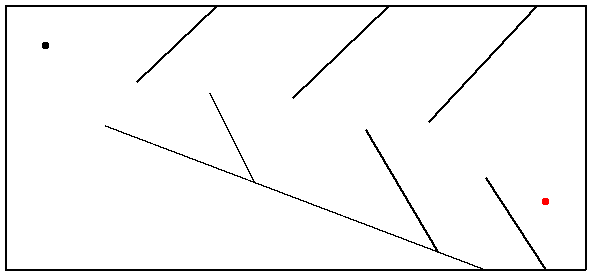

Step 10:


KeyboardInterrupt: ignored

In [37]:
# defines genetic algorithm solver
ga = SimpleGA(NPARAMS,                # number of model parameters
               sigma_init=0.5,        # initial standard deviation
               popsize=NPOPULATION,   # population size
               elite_ratio=0.1,       # percentage of the elites
               forget_best=False,     # forget the historical best elites
               weight_decay=0.00,     # weight decay coefficient
              )
ga_history = test_solver(ga)

In [41]:
from PIL import Image

imgs = []
for i in range(400):
  if i% 10==0 and i!= 10:
    imgs.append( Image.open( "maze_%d.png" % i ) )

img = imgs[0]
img.save(fp="maze.gif", format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)

print("save to", "maze.gif")

save to maze.gif
